In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import ast
from kmodes.kmodes import KModes
from sklearn.preprocessing import MultiLabelBinarizer, OneHotEncoder
from collections import Counter
import umap.umap_ as umap
import seaborn as sns

Считываем подготовленный датасет

In [2]:
df = pd.read_csv('Result_21_5.csv', encoding='')
missing_count = df.isna().sum()
print(missing_count)
df.head()

profile_id          0
profile_is_child    0
geo                 0
product_ids         0
device              0
delta               0
positive            0
negative            0
genres              0
hashtags            0
cls                 0
starts              0
progress            0
versions            0
dtype: int64


,profile_id,profile_is_child,geo,product_ids,device,delta,positive,negative,genres,hashtags,cls,starts,progress,versions
0,80d6ad93-1aa3-40dd-9f85-1bee3f2a8627,0,RU,['c164dd6d-3669-435c-a8f6-b57ca14b0a61'],['web'],29193298,0,0,"['criminal', 'drama', 'action']","['Законы улиц', 'Кино с характером', 'Криминал...",['Series'],['2024-01-22 18:35:28'],['1.1449645'],['2024-01-22 19:20:38']
1,0cec5794-90fa-467d-9857-43851054dfb3,0,BY,"['608da742-46c3-4a5d-8134-532fd391a456', 'c0c4...","['tv', 'tv', 'tv', 'tv', 'tv', 'tv', 'tv', 'tv...",590977773,0,0,"['detective', 'drama', 'comedy', 'family', 'th...","['Ведется расследование', 'Мрачная атмосфера',...","['Series', 'Series', 'Movie', 'Series', 'Serie...","['2023-12-22 14:52:55', '2025-03-16 14:13:35',...","['0.95737725', '0.014767603', '0.013667554', '...","['2023-12-22 14:52:55', '2025-03-16 14:17:38',..."
2,50820849-495c-4eab-8531-71b294585d3a,0,RU,"['55b61165-1d6d-4216-80f8-95ffda3bd528', 'e388...","['web', 'web', 'web', 'web', 'web']",36432828,11,4,"['comedy', 'family', 'family', 'fantasy', 'adv...","['Вечные ценности', 'Дела семейные', 'Душевное...","['Series', 'Series', 'Series', 'Series', 'Seri...","['2024-11-19 17:33:47', '2024-10-13 18:33:56',...","['0.09395181', '0.8115045', '0.0010829378', '0...","['2024-11-19 18:21:13', '2024-10-13 18:34:17',..."
3,0121c8ec-2066-4aa7-a788-db9e6abb65a5,1,RU,['2b085cca-54e2-44ac-b437-ee7607828d1d'],['tv'],2098083,0,0,"['entertainment', 'cartoonseries']","['Малышам', 'Про дружбу', 'Девочкам']",['Series'],['2024-12-03 04:10:59'],['0.12762572'],['2024-12-03 04:47:59']
4,97de2898-7245-4430-9eaa-1217a7476cc7,0,DE,"['b315e3c5-da4b-4dc7-bc01-62d7761e732d', '608d...","['mobile', 'mobile', 'mobile', 'mobile', 'mobi...",38886428,0,0,"['drama', 'detective', 'drama', 'detective', '...","['Звездный актерский состав', 'Советское время...","['Series', 'Series', 'Series', 'Series', 'Seri...","['2023-12-17 13:52:34', '2023-11-18 21:47:18',...","['0.009468423', '0.012955979', '0.037663378', ...","['2023-12-17 13:52:41', '2023-11-18 21:51:17',..."


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7845 entries, 0 to 7844
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   profile_id        7845 non-null   object
 1   profile_is_child  7845 non-null   int64 
 2   geo               7845 non-null   object
 3   product_ids       7845 non-null   object
 4   device            7845 non-null   object
 5   delta             7845 non-null   int64 
 6   positive          7845 non-null   int64 
 7   negative          7845 non-null   int64 
 8   genres            7845 non-null   object
 9   hashtags          7845 non-null   object
 10  cls               7845 non-null   object
 11  starts            7845 non-null   object
 12  progress          7845 non-null   object
 13  versions          7845 non-null   object
dtypes: int64(4), object(10)
memory usage: 858.2+ KB


Анализ датасета

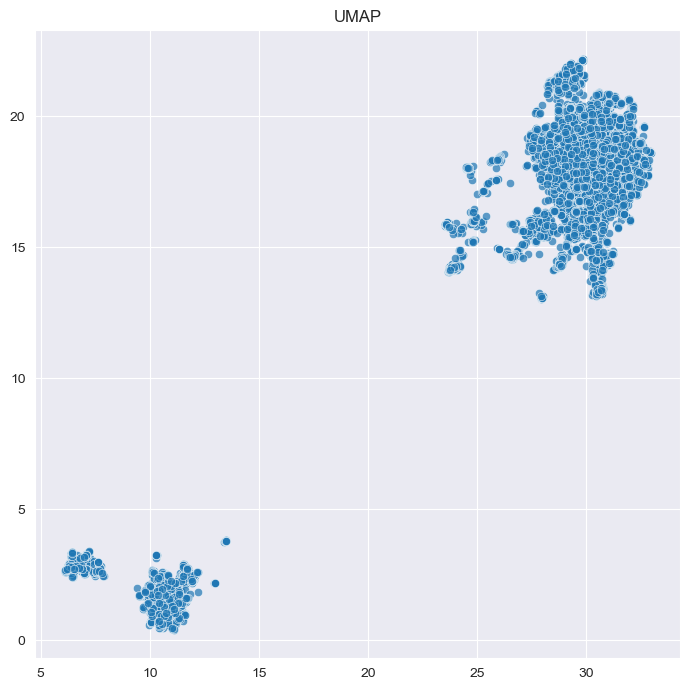

In [4]:
encoder = OneHotEncoder(sparse_output=False)
X_encoded = encoder.fit_transform(df)
reducer = umap.UMAP()
X_umap = reducer.fit_transform(X_encoded)


plt.figure(figsize=(7, 7))
sns.scatterplot(
    x=X_umap[:, 0],
    y=X_umap[:, 1],
    alpha=0.7
)
plt.title('UMAP')
plt.tight_layout()
plt.show()

Из графика видно, что точки образуют кластеры, это может указывать на то, что есть группы объектов, которые имеют схожие характеристики.

## Подготовка данных
Бинаризация

In [5]:
def most_frequent(row):        
    counts = Counter(row)
    return [index for index, value in zip(counts.keys(), counts.values()) if value == max(counts.values())]

def data_binarize(series):
    mlb = MultiLabelBinarizer()
    encoded = mlb.fit_transform(series)
    return pd.DataFrame(encoded, columns=mlb.classes_)

def time_of_day(h):
    if 5 <= h < 11: return 'Morning'
    elif 11 <= h < 17: return 'Day'
    elif 17 <= h < 23: return 'Evening'
    else: return 'Night'

classes = df['cls'].apply(lambda x: ast.literal_eval(x) if pd.notnull(x) else [])
classes_df = data_binarize(classes.apply(most_frequent))

devices = df['device'].apply(lambda x: ast.literal_eval(x) if pd.notnull(x) else [])
devices_df = data_binarize(devices.apply(most_frequent))

starts = df['starts'].apply(lambda x: ast.literal_eval(x) if pd.notnull(x) else [])

times_of_day = starts.apply(
    lambda times: [time_of_day(pd.to_datetime(t, format='%Y-%m-%d %H:%M:%S', errors='coerce').hour) for t in times if t]
)
period_df = data_binarize(times_of_day.apply(most_frequent))

weekdays = starts.apply(
    lambda times: [
        'weekend' if pd.to_datetime(t, format='%Y-%m-%d %H:%M:%S', errors='coerce').weekday() in [5, 6] else 'weekdays'
        for t in times if t
    ]
)
weekdays_df = data_binarize(weekdays.apply(most_frequent))

genres = df['genres'].apply(lambda x: ast.literal_eval(x) if pd.notnull(x) else [])
genres_df = data_binarize(genres.apply(most_frequent))

X = pd.concat([
    df['profile_is_child'].fillna(0).astype(int),
    devices_df,
    weekdays_df,
    # period_df,
    genres_df
], axis=1)
X.head()


,profile_is_child,mobile,tv,web,weekdays,weekend,action,adventure,bio,cartoon,...,music,mystic,nurseryrhymes,reality,scifi,sport,talkshow,thriller,war,youth
0,0,0,0,1,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


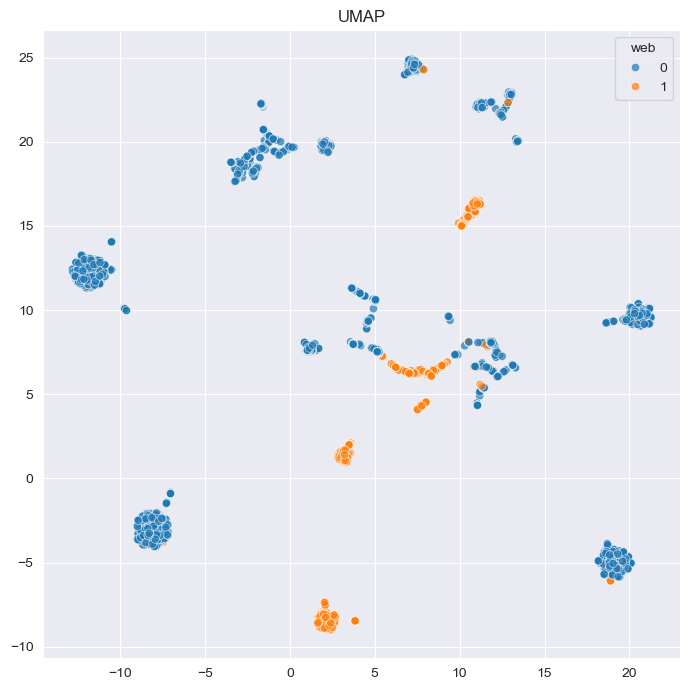

In [6]:
reducer = umap.UMAP()
X_umap = reducer.fit_transform(X)


plt.figure(figsize=(7, 7))
sns.scatterplot(
    x=X_umap[:, 0],
    y=X_umap[:, 1],
    hue=X['web'],
    alpha=0.7
)
plt.title('UMAP')
plt.tight_layout()
plt.show()

## Определяем количество кластеров

### Метод локтя

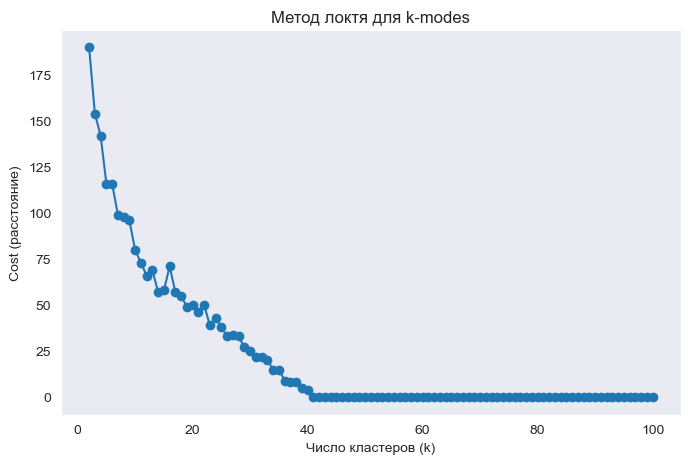

In [7]:
costs = []
K = range(2, 101)
for k in K:
    km = KModes(n_clusters=k, init='Huang', n_init=2, verbose=0, random_state=42, n_jobs=-1)
    clusters = km.fit_predict(X.head(100))
    costs.append(km.cost_)
plt.figure(figsize=(8, 5))
plt.plot(K, costs, marker='o')
plt.xlabel('Число кластеров (k)')
plt.ylabel('Cost (расстояние)')
plt.title('Метод локтя для k-modes')
plt.grid()
plt.show()

In [8]:
km = KModes(n_clusters=43, init='Huang', n_init=5, n_jobs=-1)
clusters = km.fit_predict(X)
df['k_modes_clusters'] = clusters
df.head(1000)

,profile_id,profile_is_child,geo,product_ids,device,delta,positive,negative,genres,hashtags,cls,starts,progress,versions,k_modes_clusters
0,80d6ad93-1aa3-40dd-9f85-1bee3f2a8627,0,RU,['c164dd6d-3669-435c-a8f6-b57ca14b0a61'],['web'],29193298,0,0,"['criminal', 'drama', 'action']","['Законы улиц', 'Кино с характером', 'Криминал...",['Series'],['2024-01-22 18:35:28'],['1.1449645'],['2024-01-22 19:20:38'],38
1,0cec5794-90fa-467d-9857-43851054dfb3,0,BY,"['608da742-46c3-4a5d-8134-532fd391a456', 'c0c4...","['tv', 'tv', 'tv', 'tv', 'tv', 'tv', 'tv', 'tv...",590977773,0,0,"['detective', 'drama', 'comedy', 'family', 'th...","['Ведется расследование', 'Мрачная атмосфера',...","['Series', 'Series', 'Movie', 'Series', 'Serie...","['2023-12-22 14:52:55', '2025-03-16 14:13:35',...","['0.95737725', '0.014767603', '0.013667554', '...","['2023-12-22 14:52:55', '2025-03-16 14:17:38',...",10
2,50820849-495c-4eab-8531-71b294585d3a,0,RU,"['55b61165-1d6d-4216-80f8-95ffda3bd528', 'e388...","['web', 'web', 'web', 'web', 'web']",36432828,11,4,"['comedy', 'family', 'family', 'fantasy', 'adv...","['Вечные ценности', 'Дела семейные', 'Душевное...","['Series', 'Series', 'Series', 'Series', 'Seri...","['2024-11-19 17:33:47', '2024-10-13 18:33:56',...","['0.09395181', '0.8115045', '0.0010829378', '0...","['2024-11-19 18:21:13', '2024-10-13 18:34:17',...",7
3,0121c8ec-2066-4aa7-a788-db9e6abb65a5,1,RU,['2b085cca-54e2-44ac-b437-ee7607828d1d'],['tv'],2098083,0,0,"['entertainment', 'cartoonseries']","['Малышам', 'Про дружбу', 'Девочкам']",['Series'],['2024-12-03 04:10:59'],['0.12762572'],['2024-12-03 04:47:59'],0
4,97de2898-7245-4430-9eaa-1217a7476cc7,0,DE,"['b315e3c5-da4b-4dc7-bc01-62d7761e732d', '608d...","['mobile', 'mobile', 'mobile', 'mobile', 'mobi...",38886428,0,0,"['drama', 'detective', 'drama', 'detective', '...","['Звездный актерский состав', 'Советское время...","['Series', 'Series', 'Series', 'Series', 'Seri...","['2023-12-17 13:52:34', '2023-11-18 21:47:18',...","['0.009468423', '0.012955979', '0.037663378', ...","['2023-12-17 13:52:41', '2023-11-18 21:51:17',...",22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,a2a7ba57-e776-47ef-8930-f0499abb8f79,0,RU,"['bef83a46-4f8c-45f4-92fc-071e577f230a', '2afd...","['web', 'web', 'web', 'web', 'web', 'tv', 'web...",329454970,0,0,"['drama', 'detective', 'thriller', 'drama', 't...","['Город на Неве', 'Амбициозные герои', 'Застав...","['Series', 'Series', 'Series', 'Series', 'Movi...","['2024-02-05 10:59:14', '2024-02-05 11:37:40',...","['0.09434755', '0.00028470022', '1.5514348', '...","['2024-02-05 11:18:09', '2024-02-05 11:50:15',...",13
996,a8b9500c-1008-42f6-91c4-383c60857612,0,GB,"['9eb1e01b-c101-458b-9e74-1b12d1d99978', 'e505...","['tv', 'tv', 'tv', 'tv', 'tv', 'mobile', 'tv',...",50113772,0,0,"['drama', 'comedy', 'drama', 'comedy', 'drama'...","['Фильмы с высоким бюджетом', 'Звездный актерс...","['Series', 'Movie', 'Movie', 'Movie', 'Series'...","['2023-12-21 20:15:56', '2024-04-01 11:44:38',...","['0.13922578', '1.0461295', '1.9206085', '0.00...","['2023-12-21 20:15:56', '2024-04-01 12:35:38',...",42
997,cd250048-f8c7-43a3-a4fc-69ff2f71c220,1,RU,['e3885f64-586a-4296-9438-3419132a61f3'],['tv'],359963,0,0,"['family', 'fantasy', 'adventure', 'comedy']","['Звездный актерский состав', 'Ни дня без прик...",['Series'],['2024-09-28 05:59:21'],['0.013357035'],['2024-09-28 06:04:21'],11
998,dfa837d1-89e2-409e-a7b2-dd19bfa8624c,0,RU,"['e97d3d56-a72e-4fab-9d9d-aae608588625', 'fc96...","['mobile', 'mobile', 'mobile', 'mobile', 'mobi...",40008574,0,0,"['melodrama', 'drama', 'fantasy', 'detective',...","['Истории с продолжением', 'Двое против всего ...","['Series', 'Series', 'Series', 'Series', 'Seri...","['2025-02-09 12:30:41', '2025-02-09 12:25:05',...","['0.00047281935', '0.0016011146', '0.35848168'...","['2025-02-09 12:38:41', '2025-02-09 12:25:05',...",8


In [9]:
from sklearn.metrics import silhouette_score, davies_bouldin_score
s_score = silhouette_score(X, clusters, metric='hamming')
s_score

0.6886290702099824

In [10]:
# from sklearn.metrics import silhouette_score
# 
# s_scores = []
# 
# for k in K:
#     km = KModes(n_clusters=k, init='Huang', n_init=5, verbose=0, random_state=42)
#     clusters = km.fit_predict(X.head(50))
#     labels = km.labels_
#     print(labels)
#     score = silhouette_score(X.head(50), labels)
#     s_scores.append(score)
# plt.plot(K, s_scores, 'bo-')
# plt.xlabel('Количество кластеров')
# plt.ylabel('Silhouette score')
# plt.show()